In [138]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [139]:
project_directory = os.path.dirname(os.getcwd())
raw_matches = os.path.join("data","raw","matches.csv")

In [140]:
df = pd.read_csv(os.path.join(project_directory, raw_matches), index_col=0).reindex()
df.head()

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Team,Team Code
0,Sun,10/10/1920,H,Columbus Panhandles,37-0,W,NaN,"Akron, OH",League Park,1500.0,NaN,Akron Pros,aakr
1,Sun,10/24/1920,H,Cleveland Tigers,7-0,W,NaN,"Akron, OH",League Park,5000.0,NaN,Akron Pros,aakr
2,Sun,10/31/1920,A,Canton Bulldogs,10-0,W,NaN,"Canton, OH",Lakeside Athletic Park,6000.0,NaN,Akron Pros,aakr
3,Sun,11/7/1920,A,Rock Island Independents,NaN,-,NaN,"Rock Island, IL",Douglas Park,NaN,Canceled,Akron Pros,aakr
4,Sun,11/7/1920,H,Detroit Heralds,NaN,-,NaN,"Akron, OH",League Park,NaN,Canceled,Akron Pros,aakr


In [141]:
df['Date'] = pd.to_datetime(df.Date)
df[['Team Score', 'Opponent Score']] = df.Score.str.split('-', expand=True)

df.dropna(axis=0, subset=['Score'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5794 entries, 0 to 7
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             5794 non-null   object        
 1   Date            5794 non-null   datetime64[ns]
 2   Home/Away       5794 non-null   object        
 3   Opponent        5794 non-null   object        
 4   Score           5794 non-null   object        
 5   W/L/T           5794 non-null   object        
 6   Overtime        2 non-null      object        
 7   Location        5794 non-null   object        
 8   Venue           5793 non-null   object        
 9   Attendance      5478 non-null   float64       
 10  Notes           141 non-null    object        
 11  Team            5794 non-null   object        
 12  Team Code       5794 non-null   object        
 13  Team Score      5794 non-null   object        
 14  Opponent Score  5794 non-null   object        
dtypes: date

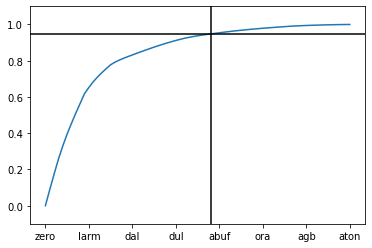

Included labels: chib...adec


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [142]:
inclusion_rate = 0.95

code_frequencies = df['Team Code'].value_counts()
cumsum_freq = code_frequencies.cumsum()
freq_max = cumsum_freq.max()
cumsum_freq = cumsum_freq / freq_max

included_labels = cumsum_freq.index[cumsum_freq < inclusion_rate]
included_x = cumsum_freq.index.get_loc(included_labels[-1])

zero_based = pd.Series([0], index=['zero']).append(cumsum_freq)

zero_based.plot()
plt.axhline(inclusion_rate, color='k')
plt.axvline(included_x + 1, color='k')
plt.ylim(-0.1, 1.1)
plt.show()
print('Included labels: ' + included_labels[0] + '...' + included_labels[-1])

teams = df['Team'][df['Team Code'].isin(included_labels)]
df = df[df.Opponent.isin(teams) & df.Team.isin(teams)]

In [ ]:
df.head()

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Team,Team Code,Team Score,Opponent Score
0,Sun,1920-10-10,H,Columbus Panhandles,37-0,W,NaN,"Akron, OH",League Park,1500.0,NaN,Akron Pros,aakr,37,0
1,Sun,1920-10-24,H,Cleveland Tigers,7-0,W,NaN,"Akron, OH",League Park,5000.0,NaN,Akron Pros,aakr,7,0
2,Sun,1920-10-31,A,Canton Bulldogs,10-0,W,NaN,"Canton, OH",Lakeside Athletic Park,6000.0,NaN,Akron Pros,aakr,10,0
5,Sun,1920-11-14,A,Cleveland Tigers,7-7,T,NaN,"Cleveland, OH",Dunn Field,8000.0,NaN,Akron Pros,aakr,7,7
6,Sun,1920-11-21,H,Dayton Triangles,13-0,W,NaN,"Akron, OH",League Park,3700.0,NaN,Akron Pros,aakr,13,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5492 entries, 0 to 7
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             5492 non-null   object        
 1   Date            5492 non-null   datetime64[ns]
 2   Home/Away       5492 non-null   object        
 3   Opponent        5492 non-null   object        
 4   Score           5492 non-null   object        
 5   W/L/T           5492 non-null   object        
 6   Overtime        2 non-null      object        
 7   Location        5492 non-null   object        
 8   Venue           5491 non-null   object        
 9   Attendance      5242 non-null   float64       
 10  Notes           131 non-null    object        
 11  Team            5492 non-null   object        
 12  Team Code       5492 non-null   object        
 13  Team Score      5492 non-null   object        
 14  Opponent Score  5492 non-null   object        
dtypes: date

In [ ]:
# Generate opponent codes
team_codes = df.groupby(['Team','Team Code']).size().reset_index().drop(columns=[0]).set_index(['Team'])
df['Opponent Code'] = df.Opponent.map(team_codes.xs)

KeyError: 'Cleveland Tigers'

<AxesSubplot:ylabel='Frequency'>

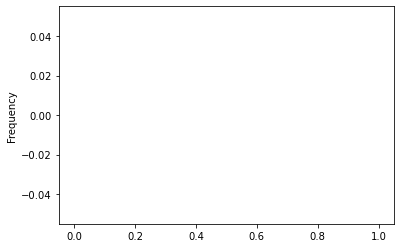

In [ ]:
df['Team Code'].value_counts().plot.hist()

In [ ]:
sort_by_date = df.sort_values(by=['Date', 'Venue', 'Home/Away'])
sort_by_date.head()

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Team,Team Code,Team Score,Opponent Score,Opponent Code


In [ ]:
team_codes

,Team Code
Team,


In [ ]:
team_codes.index

Index(['Akron Indians', 'Akron Pros', 'Akron Pros', 'Baltimore Colts',
       'Boston Braves', 'Boston Bulldogs', 'Boston Redskins', 'Boston Yanks',
       'Brooklyn Dodgers', 'Brooklyn Lions', 'Brooklyn Tigers',
       'Buffalo All-Americans', 'Buffalo Bisons', 'Buffalo Rangers',
       'Canton Bulldogs', 'Chicago Bears', 'Chicago Cardinals',
       'Cleveland Browns', 'Cleveland Bulldogs', 'Cleveland Indians',
       'Cleveland Rams', 'Columbus Panhandles', 'Columbus Tigers',
       'Dallas Cowboys', 'Dallas Texans', 'Dayton Triangles',
       'Decatur Staleys', 'Detroit Lions', 'Detroit Panthers',
       'Detroit Wolverines', 'Duluth Eskimos', 'Duluth Kelleys',
       'Frankford Yellow Jackets', 'Green Bay Packers', 'Hammond Pros',
       'Kansas City Blues', 'Kansas City Cowboys', 'Los Angeles Rams',
       'MIlwaukee Badgers', 'Milwaukee Badgers', 'Minneapolis Marines',
       'Minneapolis Redjackets', 'Minnesota Vikings', 'New York Giants',
       'New York Yankees', 'New York Ya

In [ ]:
team_codes[team_codes['Team Code'].str.lower().str.contains('cle')]

,Team Code
Team,
Cleveland Browns,cle
Cleveland Bulldogs,cle
Cleveland Indians,cle
Cleveland Rams,cle


In [ ]:
df[df.Opponent == 'Cleveland Tigers']

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Team,Team Code,Team Score,Opponent Score
1,Sun,1920-10-24,H,Cleveland Tigers,7-0,W,NaN,"Akron, OH",League Park,5000.0,NaN,Akron Pros,aakr,7,0
5,Sun,1920-11-14,A,Cleveland Tigers,7-7,T,NaN,"Cleveland, OH",Dunn Field,8000.0,NaN,Akron Pros,aakr,7,7
5,Sun,1921-11-20,H,Cleveland Tigers,22-7,W,NaN,"Chicago, IL",Cubs Park,8500.0,NaN,Decatur Staleys,adec,22,7
